### Trial

In [36]:
from jaxa.earth import je
import os
from illuminating.data_preparation.geodata_processing import get_jaxa_dataset, get_jaxa_average
import geopandas as gpd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 - Collection : JAXA.EORC_ALOS.PRISM_AW3D30.v3.2_global
 - Date : 2021-02/, 
 - Resolution : 1.25 pixels per 1 degree 
 - Bounds : [-360, -90, 360, 90]
 - Band : DSM
 - Loading images No.0 : 2021-02/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - ROI mask : masked
 - Show images : 

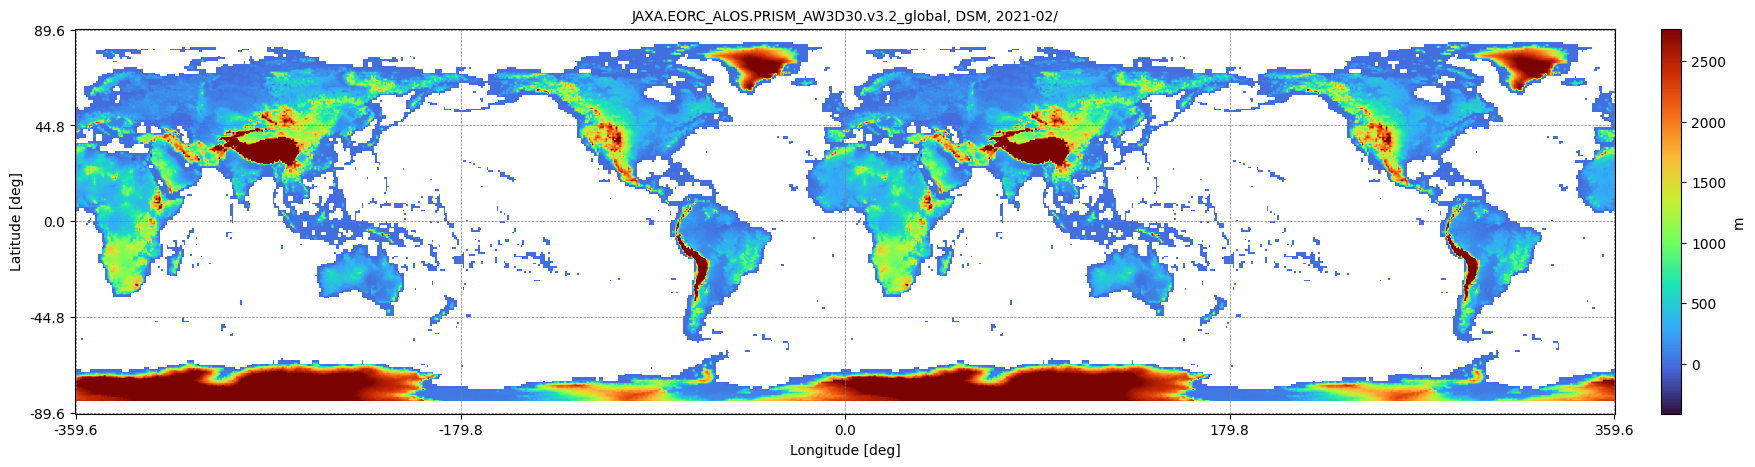

showed


In [3]:
data = je.ImageCollection(ssl_verify=True)\
         .filter_date()\
         .filter_resolution()\
         .filter_bounds()\
         .select()\
         .get_images()

# Process and show an image
img = je.ImageProcess(data)\
        .show_images()

### Land Cover

In [4]:
from illuminating.data_preparation.geodata_processing import download_gdf,create_grids
import geojson
root_path = os.path.abspath('../')
raw_data_path = os.path.join(root_path,"raw_data")

In [5]:
USA_gdf=download_gdf("USA",1)

In [6]:
california_gdf = USA_gdf[USA_gdf.NAME_1== "California"]

In [7]:
root_path = os.path.abspath('../')
json_path = os.path.join(root_path,"raw_data","california_gdf.json")
json_path

'/home/kalimdorfolk/code/mashafif/illuminating_horizons/raw_data/california_gdf.json'

In [8]:
california_gdf.to_file(json_path, driver='GeoJSON')

 - Reading feature collection data : completed
 - Searching features from collection : 1 features found!
 - Collection : Copernicus.C3S_PROBA-V_LCCS_global_yearly
 - Date : 2019/, 
 - Resolution : 20.0 pixels per 1 degree 
 - Bounds : [-124.42, 32.53, -114.12, 42.01]
 - Band : LCCS
 - Loading images No.0 : 2019/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - ROI mask : masked
 - Show images : 

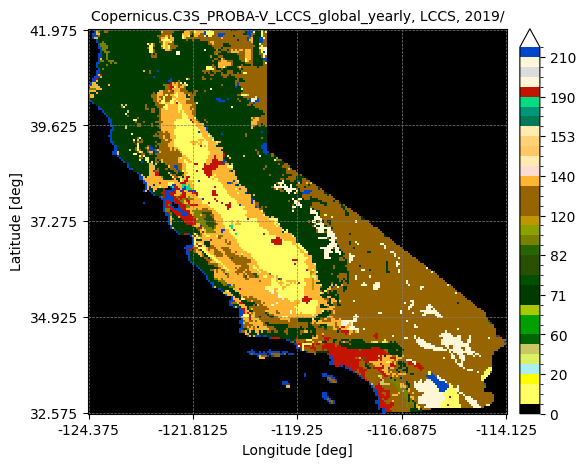

showed


In [8]:
dlim = ["2019-01-01T00:00:00","2019-01-01T00:00:00"]
ppu  = 20

# Set information of collection,band
collection = "Copernicus.C3S_PROBA-V_LCCS_global_yearly"
band       = "LCCS"

# Get feature collection data
geoj_path = json_path
geoj = je.FeatureCollection().read(geoj_path).select()

# Get an image
data = je.ImageCollection(collection=collection,ssl_verify=True)\
        .filter_date(dlim=dlim)\
        .filter_resolution(ppu=ppu)\
        .filter_bounds(geoj=geoj[0])\
        .select(band=band)\
        .get_images()

# Process and show an image
img = je.ImageProcess(data)\
        .show_images()

In [9]:
type(data)

jaxa.earth.je.ImageCollection

In [10]:
data.raster.latlim

array([[32.55, 42.  ]])

In [11]:
data.raster.lonlim

array([[-124.4, -114.1]])

In [12]:
data.raster.img[0].shape

(189, 206, 1)

In [13]:
california_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
(data.raster.lonlim[0][1]-data.raster.lonlim[0][0])

np.float64(10.300000000000011)

In [15]:
x_px = data.raster.img[0].shape[1]

In [16]:
y_px = data.raster.img[0].shape[0]

In [17]:
x_range = data.raster.lonlim[0][1]-data.raster.lonlim[0][0]
y_range = data.raster.latlim[0][1]-data.raster.latlim[0][0]

In [18]:
x_res = x_range/x_px
y_res = y_range/y_px

In [19]:
from shapely.geometry import Polygon
x_start = data.raster.lonlim[0][0]
y_start = data.raster.latlim[0][0]

In [20]:
x_start = data.raster.lonlim[0][1]
y_start = data.raster.latlim[0][1]

In [21]:
from shapely import Polygon
def to_pixel(data):
    x_px = data.raster.img[0].shape[1]
    y_px = data.raster.img[0].shape[0]
    x_res = x_range/x_px
    y_res = y_range/y_px
    x_start = data.raster.lonlim[0][0]
    y_start = data.raster.latlim[0][1]

    poly_list=[]
    for y in range(0,y_px):
        for x in range(0,x_px):
            pixel = Polygon([[x_start,y_start],
                         [x_start+x_res,y_start],
                         [x_start+y_res,y_start+y_res],
                         [x_start,y_start+y_res]])
            poly_list.append(pixel)
            x_start+=x_res
        x_start = data.raster.lonlim[0][0]
        y_start-=y_res
    return poly_list
    
    

In [22]:
import geopandas as gpd
import pandas as pd
lc_coor = gpd.GeoDataFrame(pd.DataFrame({"geometry":to_pixel(data)}),crs=california_gdf.crs)

In [23]:
import numpy as np
total_row = data.raster.img.shape[1]*data.raster.img.shape[2]
landcover = np.reshape(data.raster.img,(total_row,1))

In [24]:
lc_coor["landcover"]=landcover

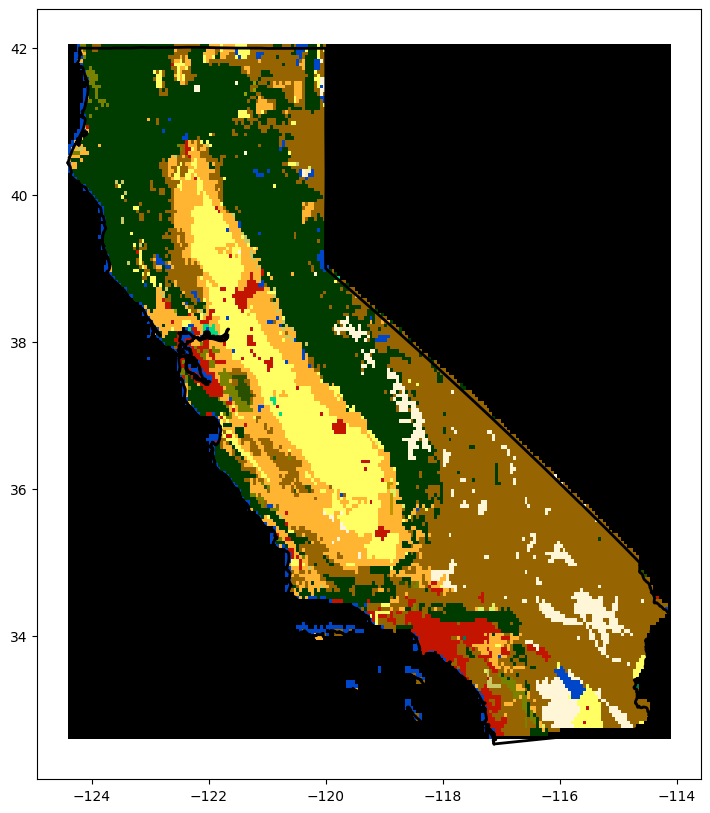

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors (replace with the actual hex values)
custom_colors = [
    '#000000', '#ffff64', '#aaf0f0','#dcf064', '#c8c864', '#006400', '#00a000', 
    '#003c00','#285000', '#788200', '#8ca000', '#be9600', '#966400', '#ffb432', 
    '#ffdcd2', '#ffebaf', '#00785a', '#009678', '#00dc82', '#c31400', 
    '#fff5d7', '#0046c8', '#ffffff'
]

# Assign specific values to each color
values = [num for num in range(0,240,10)]

# Create the custom colormap
#custom_cmap = mcolors.ListedColormap(custom_colors)
cmap, norm = mcolors.from_levels_and_colors(values, custom_colors)

fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
lc_coor.plot(ax=ax,column="landcover",cmap=cmap,norm=norm)
plt.show();

In [26]:
geojson_path = os.path.join(raw_data_path,"california_landuse.geojson")

In [27]:
geojson_path

'/home/kalimdorfolk/code/mashafif/illuminating_horizons/raw_data/california_landuse.geojson'

In [28]:
lc_coor.to_file(geojson_path,driver="GeoJSON")

### Land Cover with Library

In [44]:
lc_coor = get_jaxa_dataset(california_gdf,"landcover")

 - Collection : Copernicus.C3S_PROBA-V_LCCS_global_yearly
 - Date : 2019/, 
 - Resolution : 20.0 pixels per 1 degree 
 - Bounds : [-124.42   32.53 -114.13   42.01]
 - Band : LCCS
 - Loading images No.0 : 2019/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - ROI mask : masked


In [45]:
lc_coor.head(10)

geometry  landcover
0  POLYGON ((-124.40000 42.00000, -124.35000 42.0...        210
1  POLYGON ((-124.35000 42.00000, -124.30000 42.0...        210
2  POLYGON ((-124.30000 42.00000, -124.25000 42.0...        210
3  POLYGON ((-124.25000 42.00000, -124.20000 42.0...        210
4  POLYGON ((-124.20000 42.00000, -124.15000 42.0...         90
5  POLYGON ((-124.15000 42.00000, -124.10000 42.0...         90
6  POLYGON ((-124.10000 42.00000, -124.05000 42.0...         70
7  POLYGON ((-124.05000 42.00000, -124.00000 42.0...         70
8  POLYGON ((-124.00000 42.00000, -123.95000 42.0...        120
9  POLYGON ((-123.95000 42.00000, -123.90000 42.0...        120

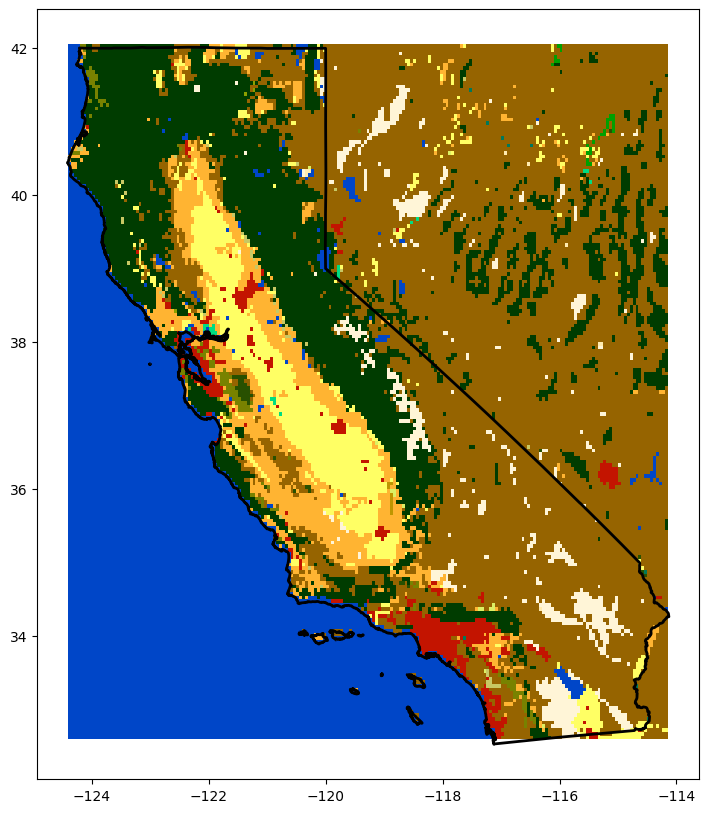

In [46]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors (replace with the actual hex values)
custom_colors = [
    '#000000', '#ffff64', '#aaf0f0','#dcf064', '#c8c864', '#006400', '#00a000', 
    '#003c00','#285000', '#788200', '#8ca000', '#be9600', '#966400', '#ffb432', 
    '#ffdcd2', '#ffebaf', '#00785a', '#009678', '#00dc82', '#c31400', 
    '#fff5d7', '#0046c8', '#ffffff'
]

# Assign specific values to each color
values = [num for num in range(0,240,10)]

# Create the custom colormap
#custom_cmap = mcolors.ListedColormap(custom_colors)
cmap, norm = mcolors.from_levels_and_colors(values, custom_colors)

fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
lc_coor.plot(ax=ax,column="landcover",cmap=cmap,norm=norm)
plt.show();

In [47]:
lc_path = os.path.join(raw_data_path,"landcover_data.geojson")
lc_coor.to_file(lc_path,driver="GeoJSON")

### Short Wave Raidation

In [ ]:
bbox = california_gdf.total_bounds

In [96]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,LineString
import numpy as np

In [129]:
def jaxaraster_to_pixel(data,x_1,x_2,y_1,y_2):
    x_start = x_1
    x_end = x_2
    y_start = y_2
    y_end = y_1
    x_px = data.shape[1]
    y_px = data.shape[0]
    x_range = x_end-x_start
    y_range = y_start-y_end
    x_res = x_range/x_px
    y_res = y_range/y_px
    # x_start = data.raster.lonlim[0][0]
    # y_start = data.raster.latlim[0][1]

    poly_list=[]
    for y in range(0,y_px):
        for x in range(0,x_px):
            pixel = Polygon([[x_start,y_start],
                        [x_start+x_res,y_start],
                        [x_start+y_res,y_start+y_res],
                        [x_start,y_start+y_res]])
            poly_list.append(pixel)
            x_start+=x_res
        x_start = x_1
        y_start-=y_res
    return poly_list

 - Reading feature collection data : completed
 - Searching features from collection : 38934 features found!
 - Collection : JAXA.JASMES_Aqua.MODIS_swr.v811_global_monthly
 - Date : 2021-01/, 2021-02/, 2021-03/, 2021-04/, 2021-05/, 2021-06/, 2021-07/, 2021-08/, 2021-09/, 2021-10/, 2021-11/, 2021-12/, 
 - Resolution : 20.0 pixels per 1 degree 
 - Bounds : [-124.42   32.53 -114.13   42.01]
 - Band : swr
 - Loading images No.0 : 2021-01/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.1 : 2021-02/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.2 : 2021-03/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

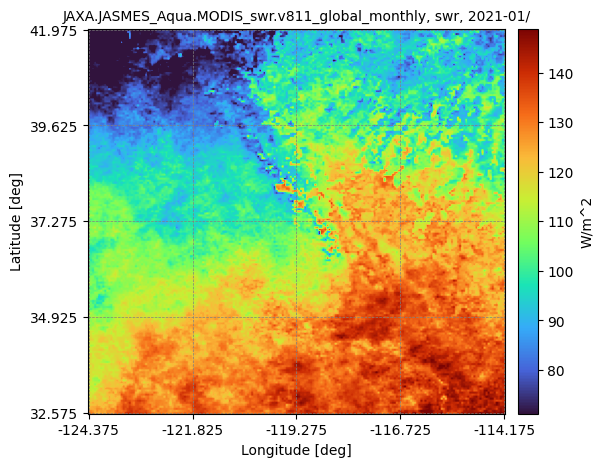

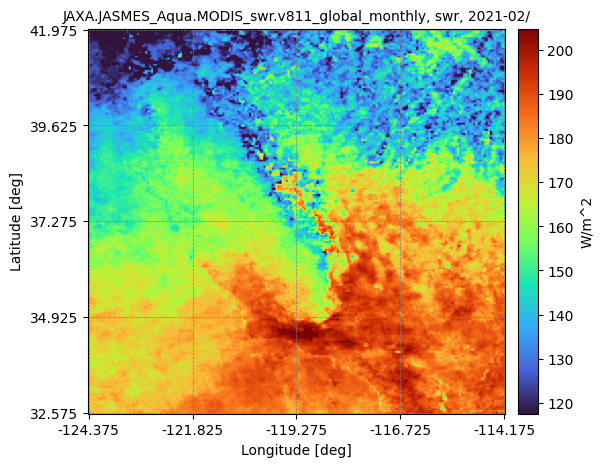

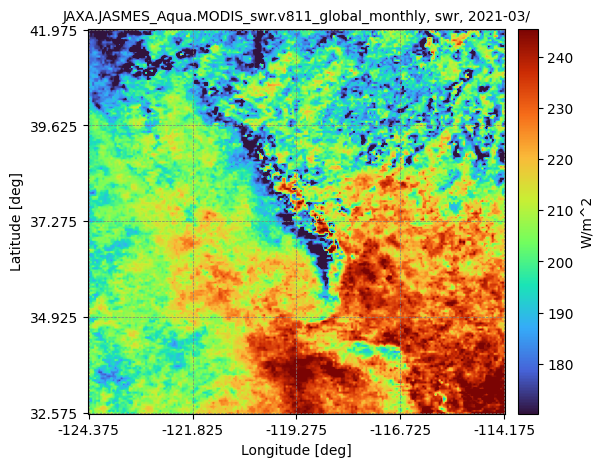

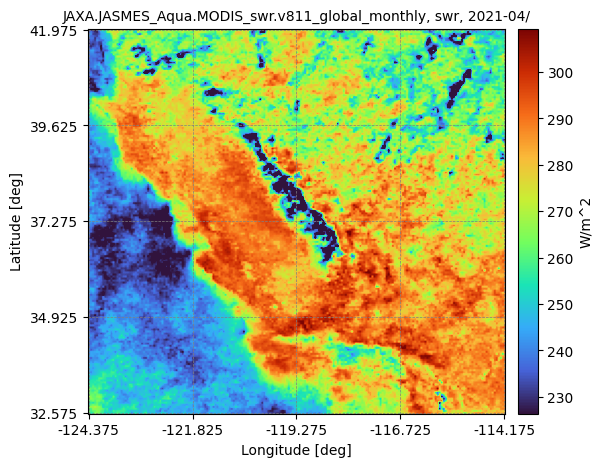

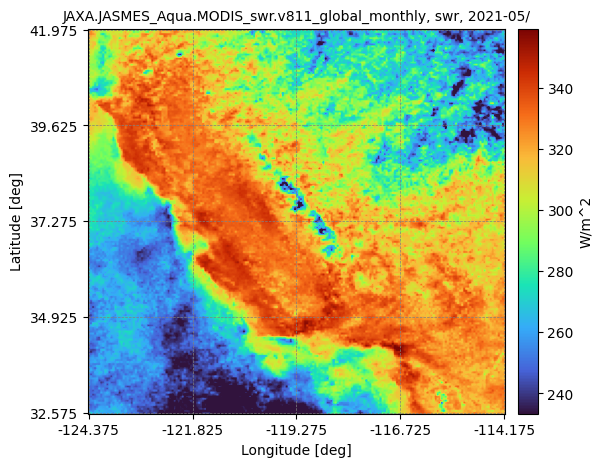

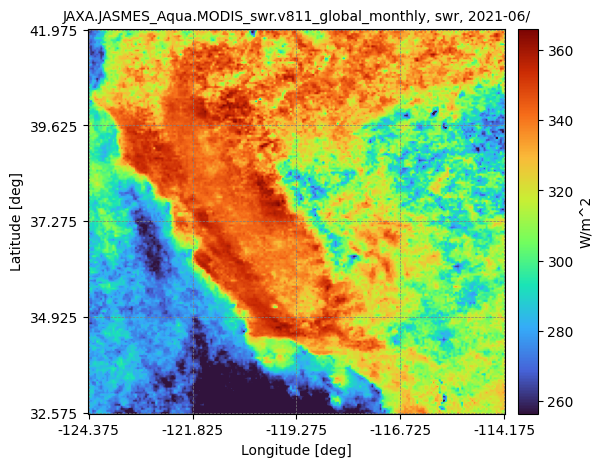

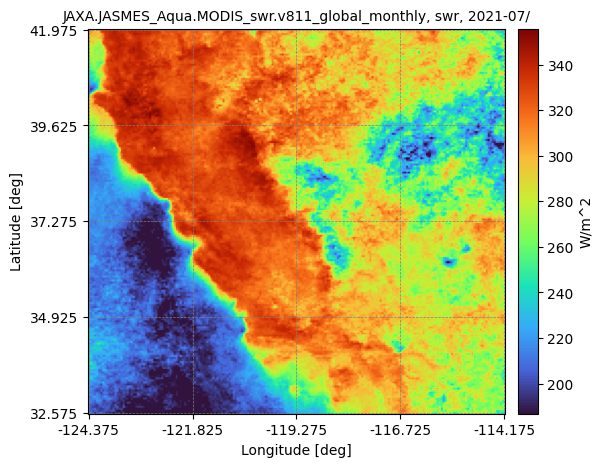

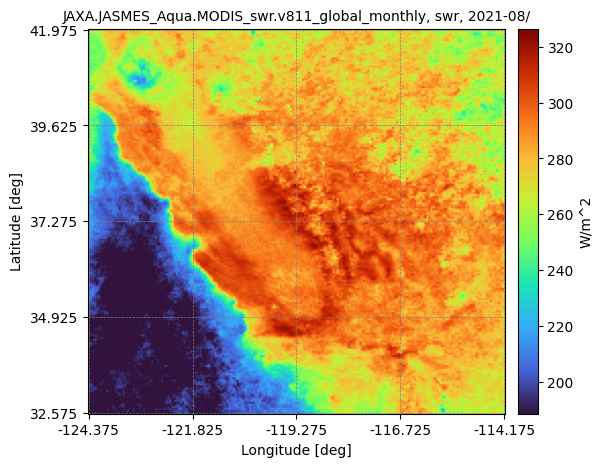

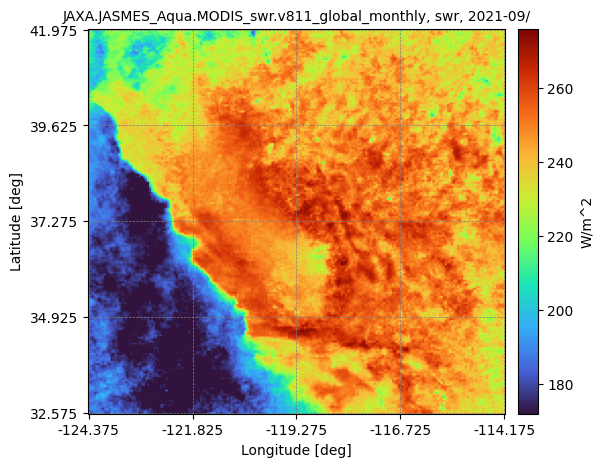

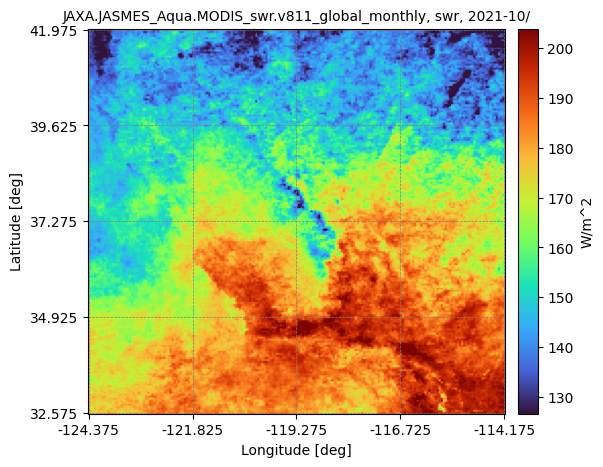

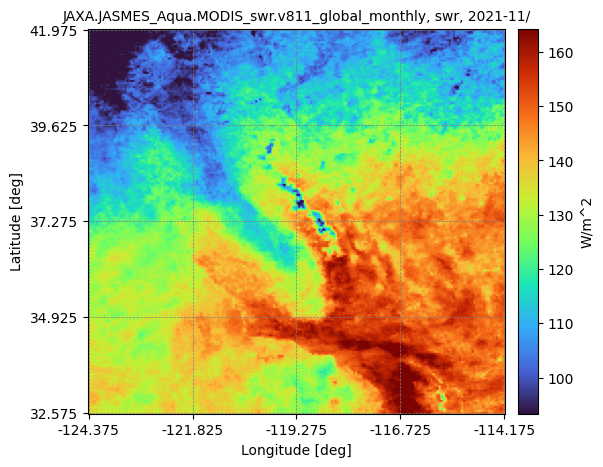

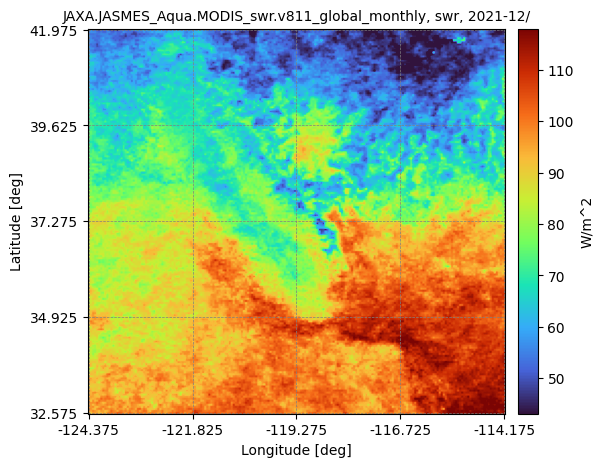

showed


In [158]:
json_name = "california_landuse.geojson"
raw_data_dir="raw_data"
start_time = "2021-01-01T00:00:00"
end_time = "2021-12-01T00:00:00"
ppu=20
crs="epsg:4326"

root_path = os.path.abspath('../')
json_path = os.path.join(root_path,raw_data_dir,json_name)

dlim = [start_time,end_time]
ppu  = ppu

# Set information of collection,band
collection = "JAXA.JASMES_Aqua.MODIS_swr.v811_global_monthly"
band       = "swr"

# Get feature collection data
geoj_path = json_path
geoj = je.FeatureCollection().read(geoj_path).select()

# Get an image
data = je.ImageCollection(collection=collection,ssl_verify=True)\
        .filter_date(dlim=dlim)\
        .filter_resolution(ppu=ppu)\
        .filter_bounds(bbox=bbox)\
        .select(band=band)\
        .get_images()

# Process and show an image
img = je.ImageProcess(data).show_images()

In [95]:
no_of_time = img.raster.img.shape[0]
#print(no_of_time)
for n in range(no_of_time):
    print(img.raster.img[n].shape)

(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)
(189, 205, 1)


In [107]:
x_start = img.raster.lonlim[0][0]
x_end = img.raster.lonlim[0][1]
x_start, x_end

(np.float64(-124.4), np.float64(-114.14999999999999))

In [108]:
y_start = img.raster.latlim[0][0]
y_end = img.raster.latlim[0][1]
y_start, y_end

(np.float64(32.550000000000004), np.float64(42.0))

In [130]:
no_of_time = img.raster.img.shape[0]
total_row = img.raster.img.shape[1]*img.raster.img.shape[2]
if no_of_time >1:
    lc_coor_res=[]
    for n in range(no_of_time):
        lc_coor = gpd.GeoDataFrame(pd.DataFrame({"geometry":jaxaraster_to_pixel(
                                            img.raster.img[n],
                                            x_start,x_end,
                                            y_start,y_end)}),
                                            crs=crs)
        landcover = np.reshape(img.raster.img[n],(total_row,1))
        lc_coor["landcover"]=landcover
        lc_coor_res.append(lc_coor)
else:
    lc_coor = gpd.GeoDataFrame(pd.DataFrame({"geometry":jaxaraster_to_pixel(img.raster.img[0])}),crs=crs)
    landcover = np.reshape(img.raster.img[0],(total_row,1))
    lc_coor["landcover"]=landcover
    lc_coor_res = lc_coor

#lc_coor_res

In [131]:
lc_coor_res[0].total_bounds

array([-124.4 ,   32.6 , -114.15,   42.05])

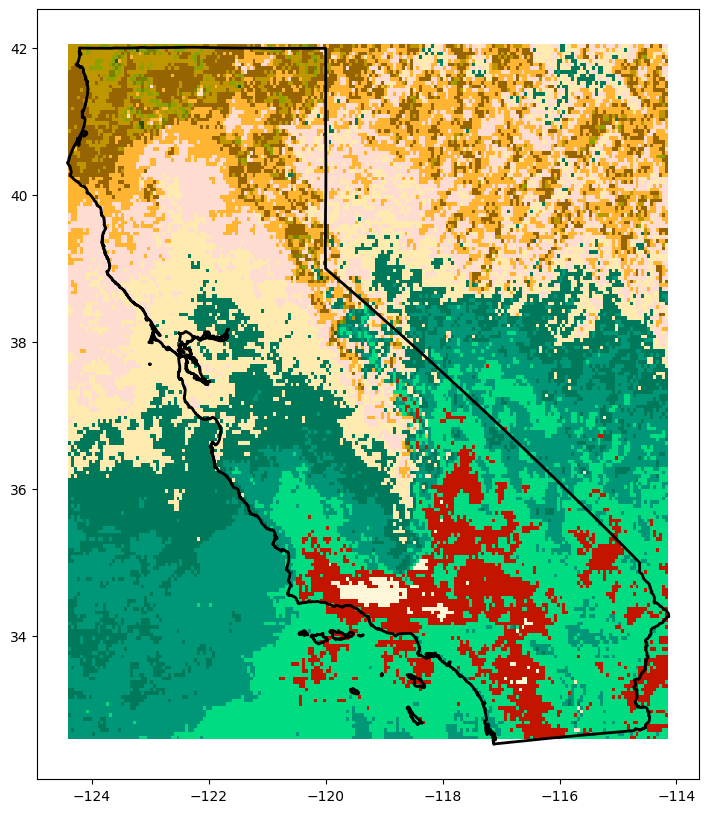

In [132]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors (replace with the actual hex values)
custom_colors = [
    '#000000', '#ffff64', '#aaf0f0','#dcf064', '#c8c864', '#006400', '#00a000', 
    '#003c00','#285000', '#788200', '#8ca000', '#be9600', '#966400', '#ffb432', 
    '#ffdcd2', '#ffebaf', '#00785a', '#009678', '#00dc82', '#c31400', 
    '#fff5d7', '#0046c8', '#ffffff'
]

# Assign specific values to each color
values = [num for num in range(0,240,10)]

# Create the custom colormap
custom_cmap = mcolors.ListedColormap(custom_colors)
cmap, norm = mcolors.from_levels_and_colors(values, custom_colors)
lc_coor = lc_coor_res[1]
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
lc_coor.plot(ax=ax,column="landcover",cmap=cmap,norm=norm)
plt.show();

### Short Wave Radiation using Library

In [40]:
radiation_db = get_jaxa_dataset(california_gdf,"sun_radiation",start_time = "2019-01-01T00:00:00",end_time = "2019-12-01T00:00:00")

 - Collection : JAXA.JASMES_Aqua.MODIS_swr.v811_global_monthly
 - Date : 2019-01/, 2019-02/, 2019-03/, 2019-04/, 2019-05/, 2019-06/, 2019-07/, 2019-08/, 2019-09/, 2019-10/, 2019-11/, 2019-12/, 
 - Resolution : 20.0 pixels per 1 degree 
 - Bounds : [-124.42   32.53 -114.13   42.01]
 - Band : swr
 - Loading images No.0 : 2019-01/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.1 : 2019-02/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.2 : 2019-03/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.3 : 2019-04/
   ------10------20------30------40------50------60------70-----

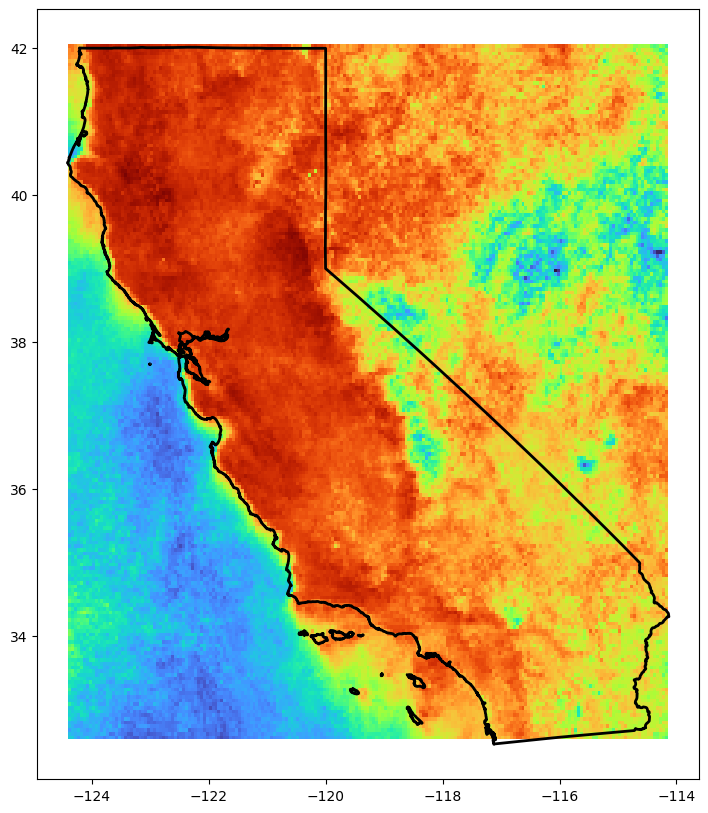

In [163]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors (replace with the actual hex values)
# custom_colors = [
#     '#000000', '#ffff64', '#aaf0f0','#dcf064', '#c8c864', '#006400', '#00a000', 
#     '#003c00','#285000']


# # Assign specific values to each color
# values = [num for num in range(100,100,10)]

# Create the custom colormap
# custom_cmap = mcolors.ListedColormap(custom_colors)
# cmap, norm = mcolors.from_levels_and_colors(values, custom_colors)
lc_coor = lc_coor_res[6]
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
lc_coor.plot(ax=ax,column="landcover",cmap="turbo")
plt.show();

In [41]:
radiation_db_avg = get_jaxa_average(lc_coor_res)

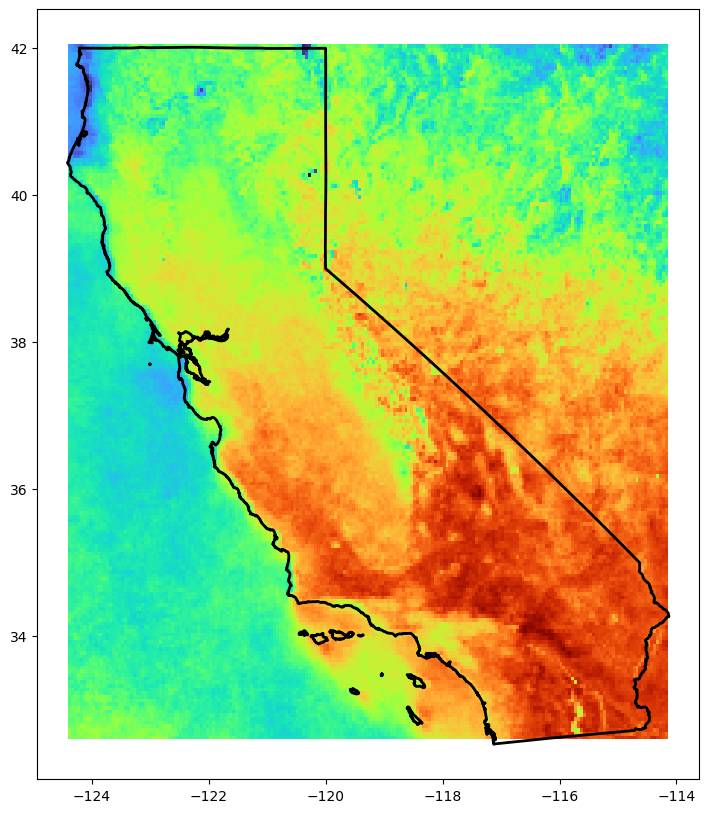

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom colors (replace with the actual hex values)
# custom_colors = [
#     '#000000', '#ffff64', '#aaf0f0','#dcf064', '#c8c864', '#006400', '#00a000', 
#     '#003c00','#285000']


# # Assign specific values to each color
# values = [num for num in range(100,100,10)]

# Create the custom colormap
# custom_cmap = mcolors.ListedColormap(custom_colors)
# cmap, norm = mcolors.from_levels_and_colors(values, custom_colors)
lc_coor = lc_coor_res[6]
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
radiation_db_avg.plot(ax=ax,column="sun_radiation",cmap="turbo")
plt.show();

In [43]:
radiation_db_path = os.path.join(raw_data_path,"radiation_yearly.geojson")
radiation_db_avg.to_file(radiation_db_path,driver='GeoJSON')

### Daytime Surface Temperature

In [49]:
day_temp_gdf_list = get_jaxa_dataset(california_gdf,"daytime_temperature",start_time = "2019-01-01T00:00:00",end_time = "2019-12-01T00:00:00")

 - Collection : JAXA.G-Portal_GCOM-C.SGLI_standard.L3-LST.daytime.v3_global_monthly
 - Date : 2019-01/, 2019-02/, 2019-03/, 2019-04/, 2019-05/, 2019-06/, 2019-07/, 2019-08/, 2019-09/, 2019-10/, 2019-11/, 2019-12/, 
 - Resolution : 20.0 pixels per 1 degree 
 - Bounds : [-124.42   32.53 -114.13   42.01]
 - Band : LST
 - Loading images No.0 : 2019-01/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.1 : 2019-02/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.2 : 2019-03/
   ------10------20------30------40------50------60------70------80------90-----100
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 - Loading images No.3 : 2019-04/
   ------10------20------30------40------50

In [50]:
day_temp_gdf_avg = get_jaxa_average(day_temp_gdf_list)

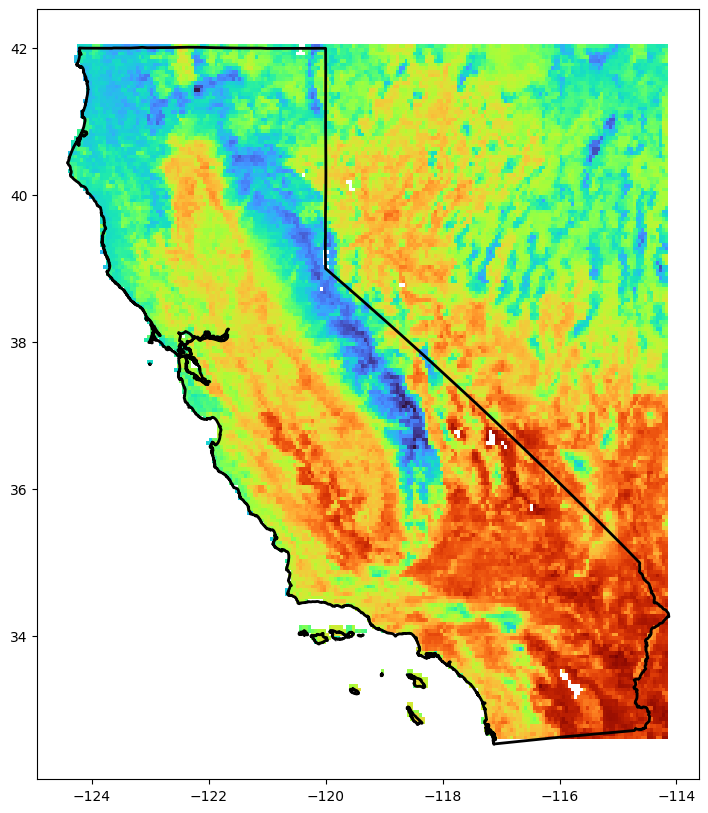

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


lc_coor = lc_coor_res[6]
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
day_temp_gdf_avg.plot(ax=ax,column="daytime_temperature",cmap="turbo")
plt.show();

In [53]:
temp_db_path = os.path.join(raw_data_path,"daytime_surface_yearly.geojson")
day_temp_gdf_avg.to_file(temp_db_path,driver='GeoJSON')